# 数据加载、时间序列转换与可视化

本 notebook 从已保存的 CSV 文件加载数据，转换为时间序列格式（适配 pysindy），并进行可视化

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) 

import matplotlib.pyplot as plt
import pickle   
import numpy as np  
from datetime import datetime  
import pandas as pd
import scipy
import seaborn as sns
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools.tools import get_positive_contributions, compute_entropy, print_equations, fit_sindy_sr3_robust, lift_time_delay, plot_station
from tools.tools import split_and_group_matrices, plot_macro_serie
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from read_data_improved import main, format_timeseries_data

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 步骤 1: 生成并保存数据

In [2]:
# print("="*60)
# print("生成训练和测试数据...")
# print("="*60)
# main(atten_type = 1, trial_type = 1)

## 步骤 2: 从 CSV 文件加载数据

In [2]:
print("\n" + "="*60)
print("加载保存的数据...")
print("="*60)

train_data = {}
test_data = {}

for stage in [1, 2, 3]:
    base_path = f'./visual_inducted_conscious/1/stage{stage}'
    train_data[stage] = np.load(f'{base_path}/train_seqs.npy')  
    test_data[stage] = np.load(f'{base_path}/test_seqs.npy')  
    



加载保存的数据...


## 步骤 5: 绘制时间序列图

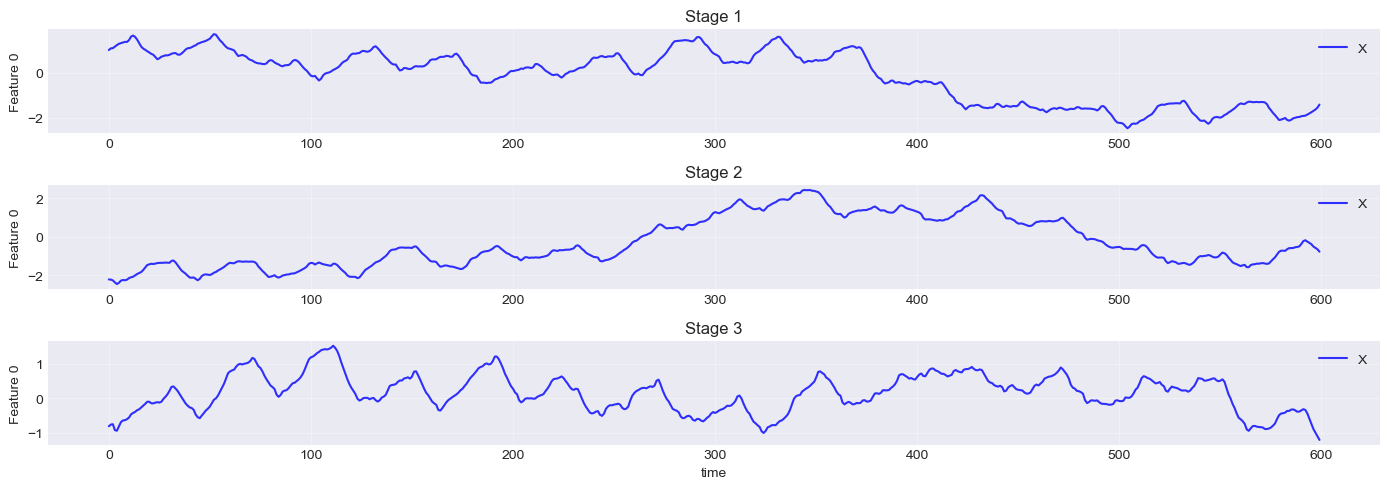

✓ 时间序列图绘制完成


In [3]:
# 绘制 3 个阶段的时间序列
fig, axes = plt.subplots(3, 1, figsize=(14, 5))
feature = 0  # 只绘制第一个特征

for idx, stage in enumerate([1, 2, 3]):
    # 获取数据
    X_train = train_data[stage][0]
    
    # 绘制特征值
    axes[idx].plot(X_train[:, feature], 'b-', linewidth=1.5, alpha=0.8, label='X')
    axes[idx].set_ylabel(f'Feature {feature}')
    axes[idx].set_title(f'Stage {stage}')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    

axes[2].set_xlabel('time')
plt.tight_layout()
plt.show()

print("✓ 时间序列图绘制完成")

## 步骤 8: 数据准备完成 - 可直接用于 pysindy

In [58]:
stage = 3
x_data = []
for i in range(len(train_data[stage])):
    x_data.append(train_data[stage][i])
micro_name = []
for i in range(x_data[0].shape[1]):
    micro_name.append('x'+str(i))
micro_name, x_data[0].shape, len(x_data)

(['x0',
  'x1',
  'x2',
  'x3',
  'x4',
  'x5',
  'x6',
  'x7',
  'x8',
  'x9',
  'x10',
  'x11',
  'x12',
  'x13',
  'x14',
  'x15',
  'x16',
  'x17',
  'x18',
  'x19',
  'x20',
  'x21',
  'x22',
  'x23',
  'x24',
  'x25',
  'x26',
  'x27',
  'x28',
  'x29',
  'x30',
  'x31',
  'x32',
  'x33',
  'x34',
  'x35',
  'x36',
  'x37',
  'x38',
  'x39',
  'x40',
  'x41',
  'x42',
  'x43',
  'x44',
  'x45',
  'x46',
  'x47',
  'x48',
  'x49',
  'x50',
  'x51',
  'x52',
  'x53',
  'x54',
  'x55',
  'x56',
  'x57',
  'x58',
  'x59',
  'x60',
  'x61',
  'x62',
  'x63',
  'x64',
  'x65',
  'x66',
  'x67',
  'x68',
  'x69',
  'x70',
  'x71',
  'x72',
  'x73',
  'x74',
  'x75',
  'x76',
  'x77',
  'x78',
  'x79',
  'x80',
  'x81',
  'x82',
  'x83',
  'x84',
  'x85',
  'x86',
  'x87',
  'x88',
  'x89',
  'x90',
  'x91',
  'x92',
  'x93',
  'x94',
  'x95',
  'x96',
  'x97',
  'x98',
  'x99',
  'x100',
  'x101',
  'x102',
  'x103',
  'x104',
  'x105',
  'x106',
  'x107',
  'x108',
  'x109',
  'x110',


# 选择观测函数

In [59]:
# n_delays = 3
# delay_interval = 5
# H, names = lift_time_delay(x_data, feature_names=micro_name, n_delays=n_delays, delay_interval=delay_interval)
# x_data_lift = H


# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=2,include_bias=False,interaction_only=True)
library_functions = [
    lambda x: x,
    lambda x: x**2
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide 

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

print(x_data_lift[0].shape)
print(names)

(600, 141)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x132', 'x133', 'x134', 'x135', 'x136', 'x

# 进行拟合

In [60]:
discrete_time = True
dt = 1
thresholds = np.logspace(-1, 1, 7)
print(thresholds)
model, results = fit_sindy_sr3_robust(x_data_lift, ide, names, penalty='l1', discrete_time=discrete_time, max_iter=500, thresholds=thresholds, metric='aic', tol=1e-4, nu=1)

[ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
✓ 检测到 139 个时间序列（单独拟合，不拼接）
  序列 1: 600 个样本, 141 个维度
  序列 2: 600 个样本, 141 个维度
  序列 3: 600 个样本, 141 个维度
  序列 4: 600 个样本, 141 个维度
  序列 5: 600 个样本, 141 个维度
  序列 6: 600 个样本, 141 个维度
  序列 7: 600 个样本, 141 个维度
  序列 8: 600 个样本, 141 个维度
  序列 9: 600 个样本, 141 个维度
  序列 10: 600 个样本, 141 个维度
  序列 11: 600 个样本, 141 个维度
  序列 12: 600 个样本, 141 个维度
  序列 13: 600 个样本, 141 个维度
  序列 14: 600 个样本, 141 个维度
  序列 15: 600 个样本, 141 个维度
  序列 16: 600 个样本, 141 个维度
  序列 17: 600 个样本, 141 个维度
  序列 18: 600 个样本, 141 个维度
  序列 19: 600 个样本, 141 个维度
  序列 20: 600 个样本, 141 个维度
  序列 21: 600 个样本, 141 个维度
  序列 22: 600 个样本, 141 个维度
  序列 23: 600 个样本, 141 个维度
  序列 24: 600 个样本, 141 个维度
  序列 25: 600 个样本, 141 个维度
  序列 26: 600 个样本, 141 个维度
  序列 27: 600 个样本, 141 个维度
  序列 28: 600 个样本, 141 个维度
  序列 29: 600 个样本, 141 个维度
  序列 30: 600 个样本, 141 个维度
  序列 31: 600 个样本, 141 个维度
  序列 32: 600 个样本, 141 个维度
  序列 33: 600 个样本, 141 个维度
  序列 34: 600 个样本, 141 个维度
  序列 35: 600

参数扫描 (l1): 100%|██████████| 7/7 [03:05<00:00, 26.54s/it]


最佳模型 (AIC) | Penalty: L1
参数 (Threshold): 4.642e+00
参数 (Lambda):    4.642e+00
MSE:         6.0627e-03
k:   246.0
评分 (aic):  -5634.7285

发现的方程:
(x0)[k+1] = 0.996 x0[k]
(x1)[k+1] = 0.998 x1[k]
(x2)[k+1] = 0.996 x2[k]
(x3)[k+1] = 0.995 x3[k]
(x4)[k+1] = 0.961 x4[k] + -0.035 x5[k]
(x5)[k+1] = -0.064 x3[k] + -0.125 x4[k] + 0.812 x5[k]
(x6)[k+1] = 0.979 x6[k] + -0.119 x107[k]
(x7)[k+1] = 0.985 x7[k] + -0.109 x107[k]
(x8)[k+1] = 0.988 x8[k] + -0.104 x107[k]
(x9)[k+1] = 0.995 x9[k] + -0.086 x107[k]
(x10)[k+1] = 0.998 x10[k] + -0.062 x107[k]
(x11)[k+1] = 0.999 x11[k] + -0.055 x107[k]
(x12)[k+1] = 0.998 x12[k] + -0.053 x107[k]
(x13)[k+1] = 0.997 x13[k] + -0.064 x107[k]
(x14)[k+1] = 0.997 x14[k] + -0.070 x107[k]
(x15)[k+1] = -0.008 x14[k] + 1.005 x15[k] + -0.071 x107[k]
(x16)[k+1] = 0.998 x16[k] + -0.071 x107[k]
(x17)[k+1] = 0.998 x17[k] + -0.067 x107[k]
(x18)[k+1] = 0.999 x18[k] + -0.066 x107[k]
(x19)[k+1] = 1.000 x19[k] + -0.059 x107[k]
(x20)[k+1] = 0.998 x20[k]
(x21)[k+1] = 0.998 x21[k]
(x22)[

In [18]:
# 离散的迭代方程 or 连续的微分方程
discrete_time = True
dt = 1
ide = ps.IdentityLibrary()
# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l2")
lasso_optimizer = Lasso(alpha=0.01, max_iter=20000, fit_intercept=True)
stlsq_optimizer = ps.STLSQ(threshold=0.01, alpha=0.9, verbose=True)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

(f0(x0))' = 0.011 f0(x6) + 0.002 f0(x8) + -0.025 f0(x62) + 0.003 f0(x95) + 0.009 f0(x98) + -0.006 f1(x6)
(f0(x1))' = 0.008 f0(x6) + -0.006 f0(x62) + -0.004 f1(x6)
(f0(x2))' = 0.008 f0(x6) + -0.019 f0(x62) + 0.002 f0(x95) + 0.004 f0(x98) + 0.011 f0(x107) + -0.005 f1(x6)
(f0(x3))' = 0.010 f0(x6) + 0.001 f0(x8) + -0.025 f0(x62) + 0.003 f0(x95) + 0.007 f0(x98) + 0.014 f0(x107) + -0.004 f1(x6)
(f0(x4))' = 0.000
(f0(x5))' = -0.003 f0(x6) + 0.006 f0(x62) + -0.018 f0(x107)
(f0(x6))' = 0.003 f0(x39) + 0.006 f0(x62) + -0.113 f0(x107) + -0.009 f1(x107)
(f0(x7))' = 0.001 f0(x39) + 0.006 f0(x62) + -0.104 f0(x107) + -0.008 f1(x107)
(f0(x8))' = 0.007 f0(x62) + -0.098 f0(x107) + -0.007 f1(x107)
(f0(x9))' = 0.004 f0(x62) + -0.080 f0(x107) + -0.003 f1(x107)
(f0(x10))' = -0.056 f0(x107)
(f0(x11))' = -0.048 f0(x107)
(f0(x12))' = -0.046 f0(x107)
(f0(x13))' = -0.057 f0(x107)
(f0(x14))' = 0.001 f0(x62) + -0.064 f0(x107) + -0.001 f1(x107)
(f0(x15))' = -0.064 f0(x107) + -0.001 f1(x107)
(f0(x16))' = 0.001 f0(x6

In [25]:
model.score(x_data_lift, t=dt)

0.9970811986778361

In [45]:
model.score(x_data_lift, t=dt)

0.9973370600167814

In [61]:
model.score(x_data_lift, t=dt)

0.99663893514344

# 保存模型

In [62]:
def save_model_pickle(model, filepath):  
    """  
    使用 pickle 保存 SINDy 模型  
    """  
    with open(filepath, 'wb') as f:  
        pickle.dump(model, f)  
    print(f"✓ 模型已保存到: {filepath}")  

def load_model_pickle(filepath):  
    """  
    使用 pickle 加载 SINDy 模型  
    """  
    with open(filepath, 'rb') as f:  
        model = pickle.load(f)  
    print(f"✓ 模型已加载: {filepath}")  
    return model  

print("\n=== 方式1：简单保存（pickle）===")  
save_model_pickle(model, f'stage{stage}_dis_{discrete_time}.pkl')  
model = load_model_pickle(f'stage{stage}_dis_{discrete_time}.pkl')  
model.print()


=== 方式1：简单保存（pickle）===
✓ 模型已保存到: stage3_dis_True.pkl
✓ 模型已加载: stage3_dis_True.pkl
(x0)[k+1] = 0.996 x0[k]
(x1)[k+1] = 0.998 x1[k]
(x2)[k+1] = 0.996 x2[k]
(x3)[k+1] = 0.995 x3[k]
(x4)[k+1] = 0.961 x4[k] + -0.035 x5[k]
(x5)[k+1] = -0.064 x3[k] + -0.125 x4[k] + 0.812 x5[k]
(x6)[k+1] = 0.979 x6[k] + -0.119 x107[k]
(x7)[k+1] = 0.985 x7[k] + -0.109 x107[k]
(x8)[k+1] = 0.988 x8[k] + -0.104 x107[k]
(x9)[k+1] = 0.995 x9[k] + -0.086 x107[k]
(x10)[k+1] = 0.998 x10[k] + -0.062 x107[k]
(x11)[k+1] = 0.999 x11[k] + -0.055 x107[k]
(x12)[k+1] = 0.998 x12[k] + -0.053 x107[k]
(x13)[k+1] = 0.997 x13[k] + -0.064 x107[k]
(x14)[k+1] = 0.997 x14[k] + -0.070 x107[k]
(x15)[k+1] = -0.008 x14[k] + 1.005 x15[k] + -0.071 x107[k]
(x16)[k+1] = 0.998 x16[k] + -0.071 x107[k]
(x17)[k+1] = 0.998 x17[k] + -0.067 x107[k]
(x18)[k+1] = 0.999 x18[k] + -0.066 x107[k]
(x19)[k+1] = 1.000 x19[k] + -0.059 x107[k]
(x20)[k+1] = 0.998 x20[k]
(x21)[k+1] = 0.998 x21[k]
(x22)[k+1] = 1.005 x22[k] + -0.044 x107[k]
(x23)[k+1] = 0.998 x23

# 加载模型

In [ ]:
stage = 1
discrete_time = True
model = load_model_pickle(f'stage{stage}_dis_{discrete_time}.pkl')  
model.print()

# 多步预测

In [63]:
# # 单时间序列
# init_data = x_data_lift[0,:]
# # 多时间序列
test_idx = 3
init_data = x_data_lift[test_idx][0,:]
step_pred = 10
t = range(step_pred)

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(10, 141)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_31985/2295418408.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


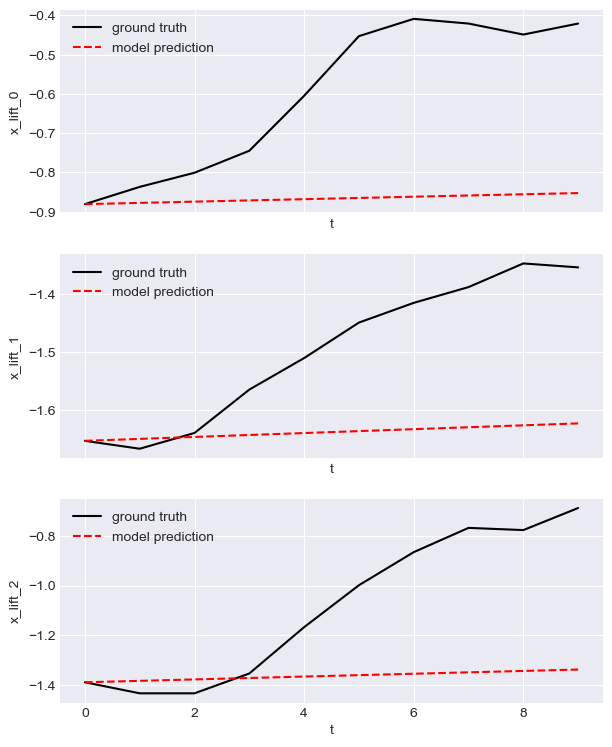

In [64]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[test_idx][:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

# 分析K

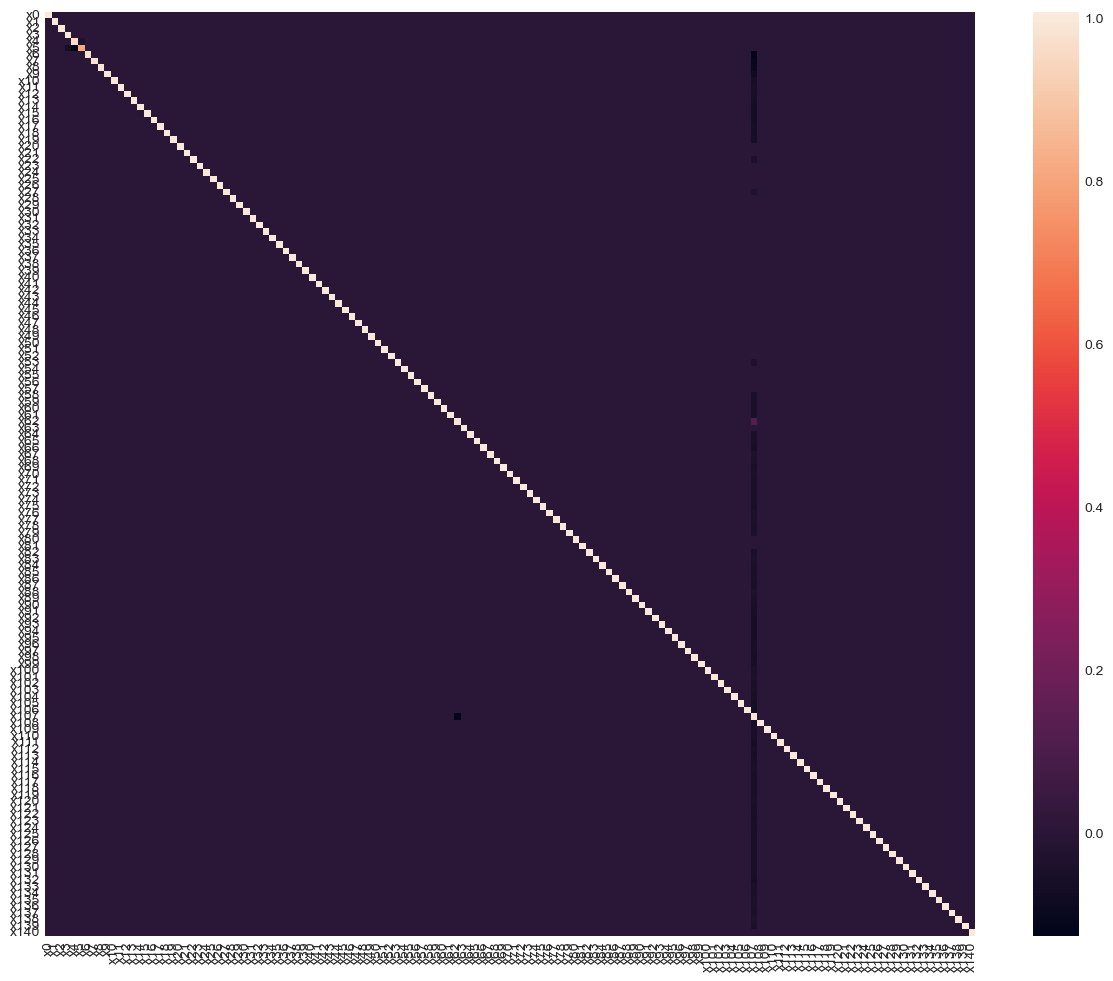

In [65]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

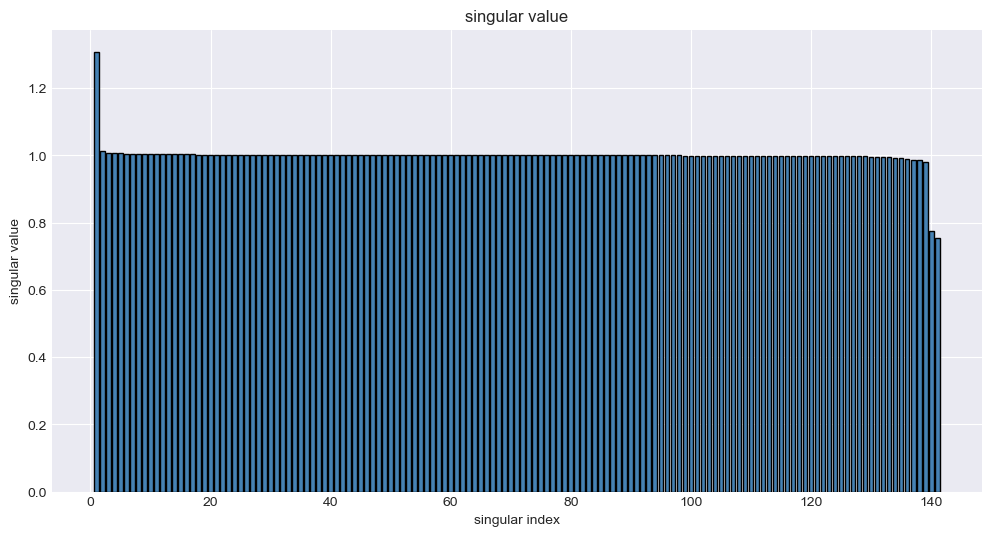

In [66]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

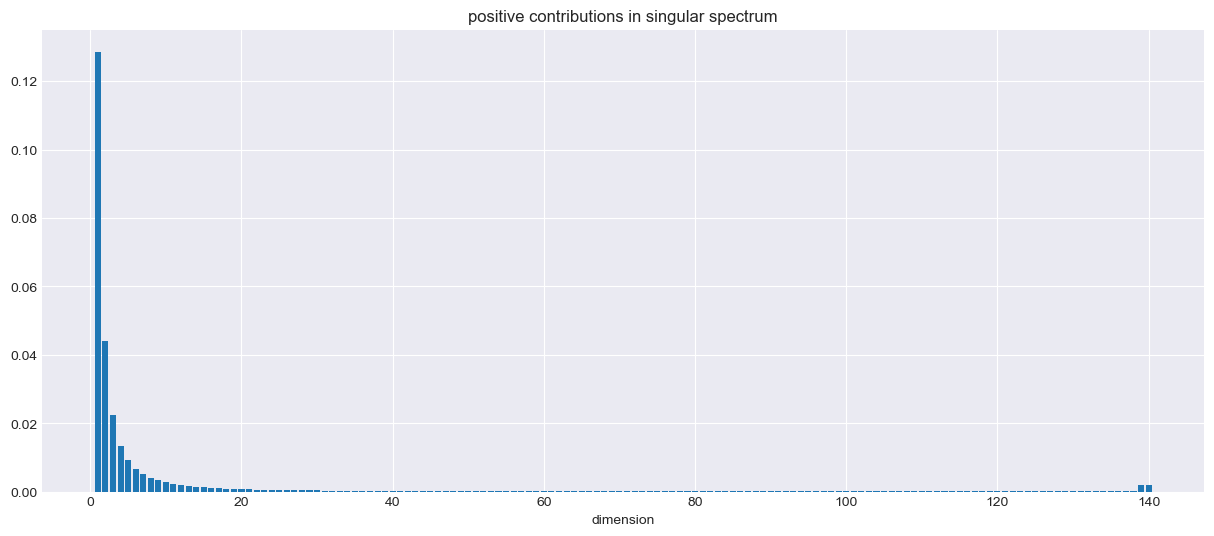

In [67]:
diff = get_positive_contributions(S)
#diff = diff[:50]
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [34]:
print(compute_entropy(diff))

3.3292383394411402


In [52]:
print(compute_entropy(diff))

3.4502002574570736


In [68]:
print(compute_entropy(diff))

3.1222699072617566


In [35]:
rank = 1
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

0.3170670348644483


In [53]:
rank = 1
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

0.32538084465069006


In [69]:
rank = 1
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

0.30959874522713104


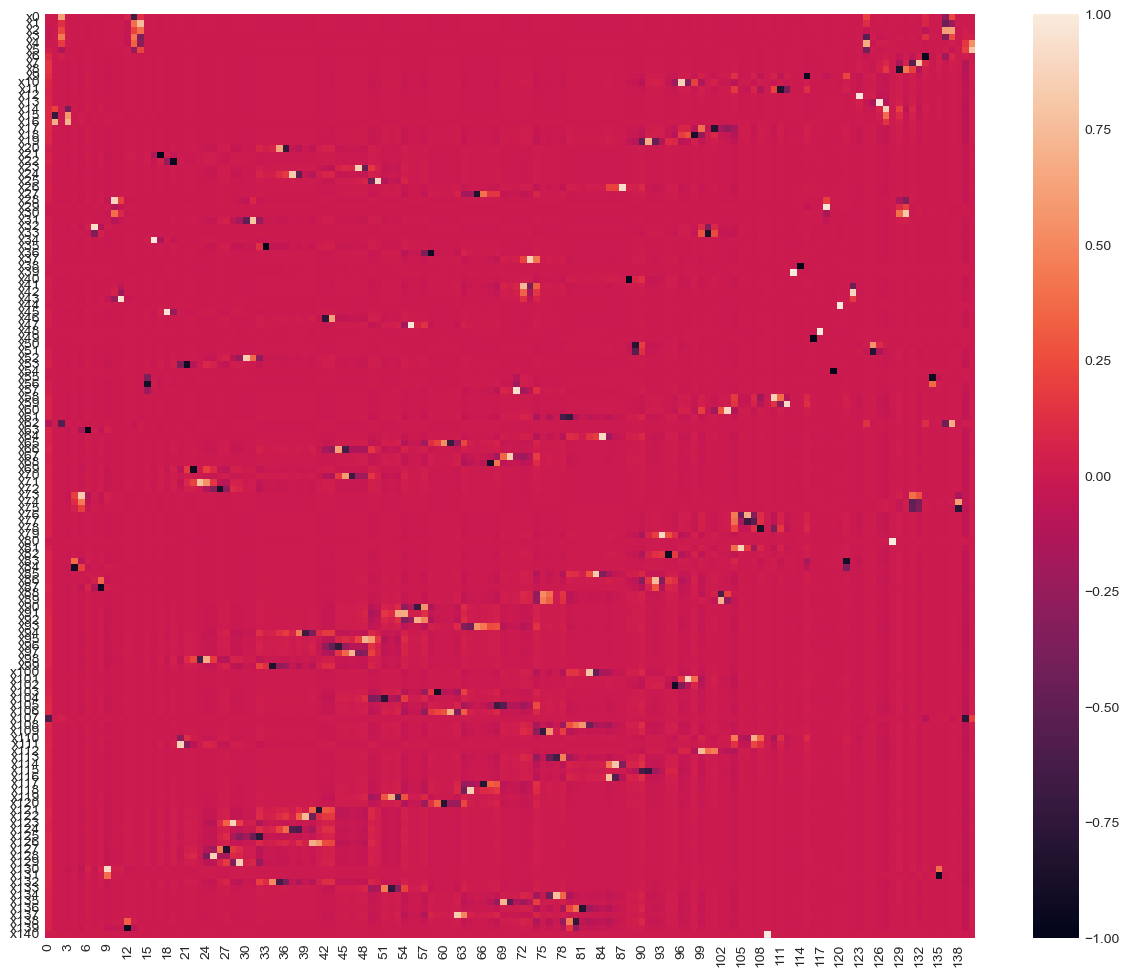

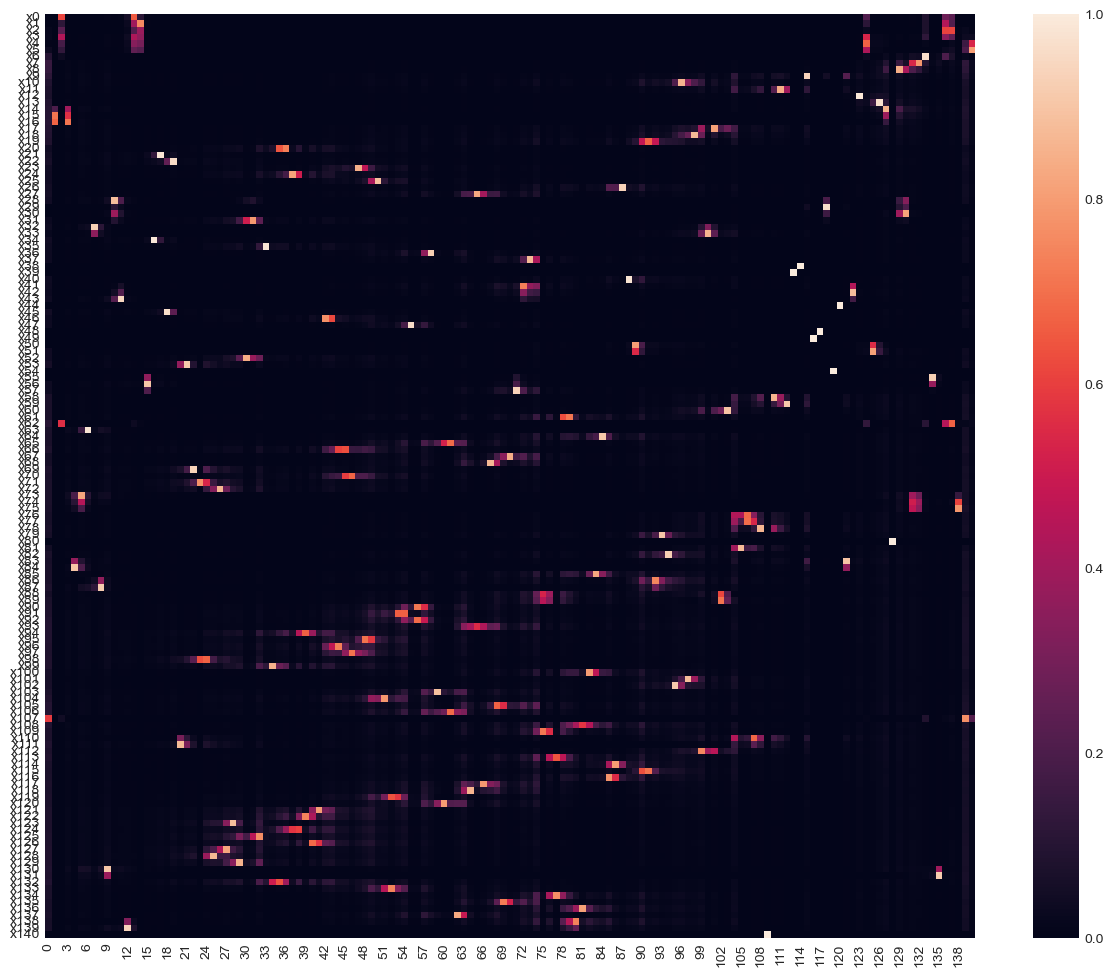

In [54]:
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

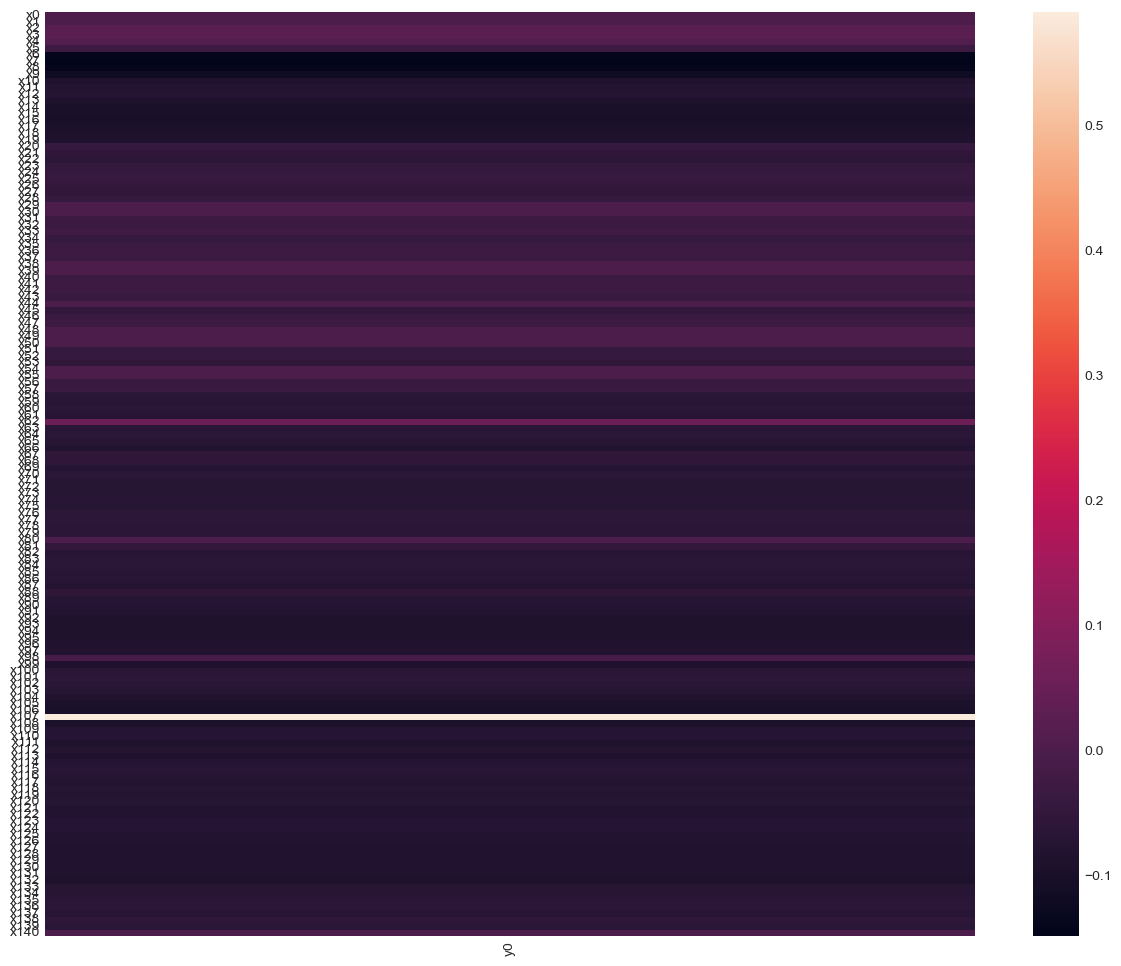

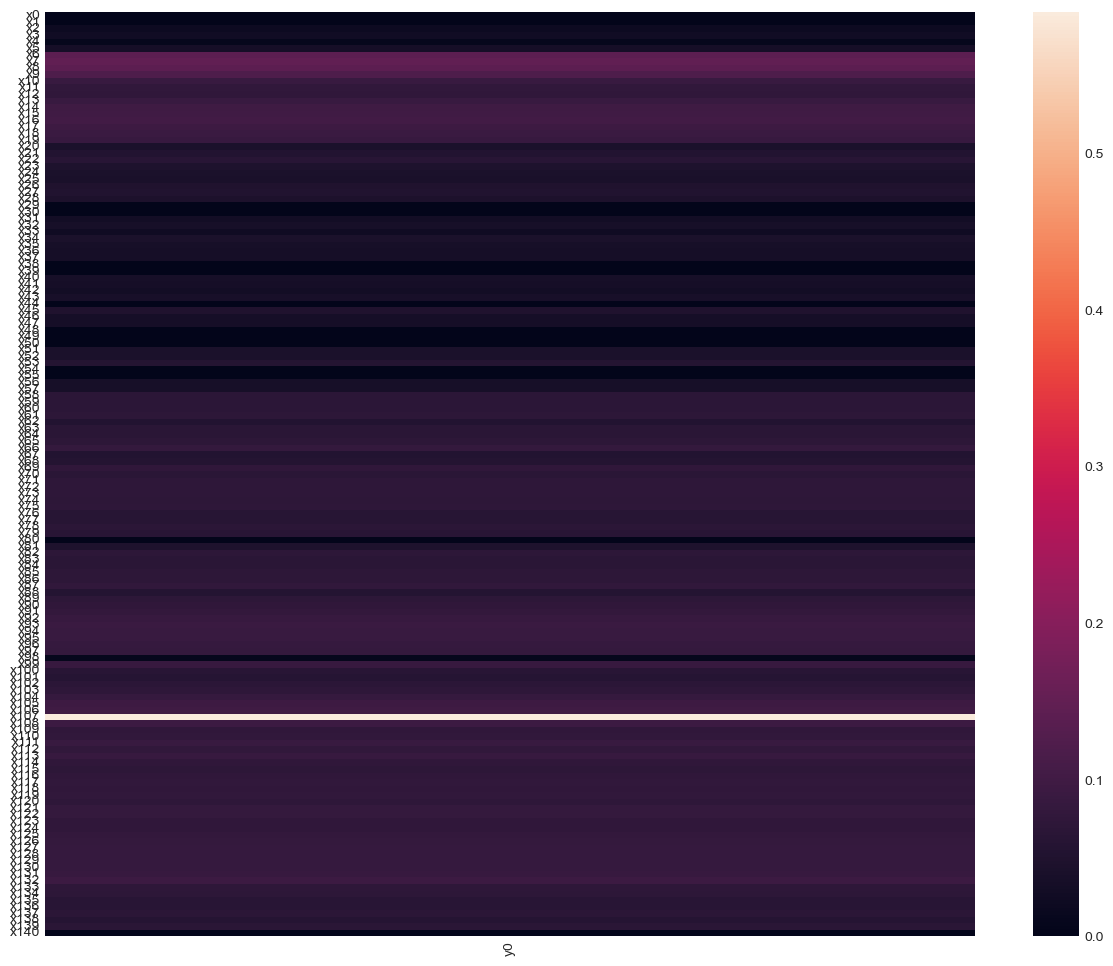

In [37]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)    
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

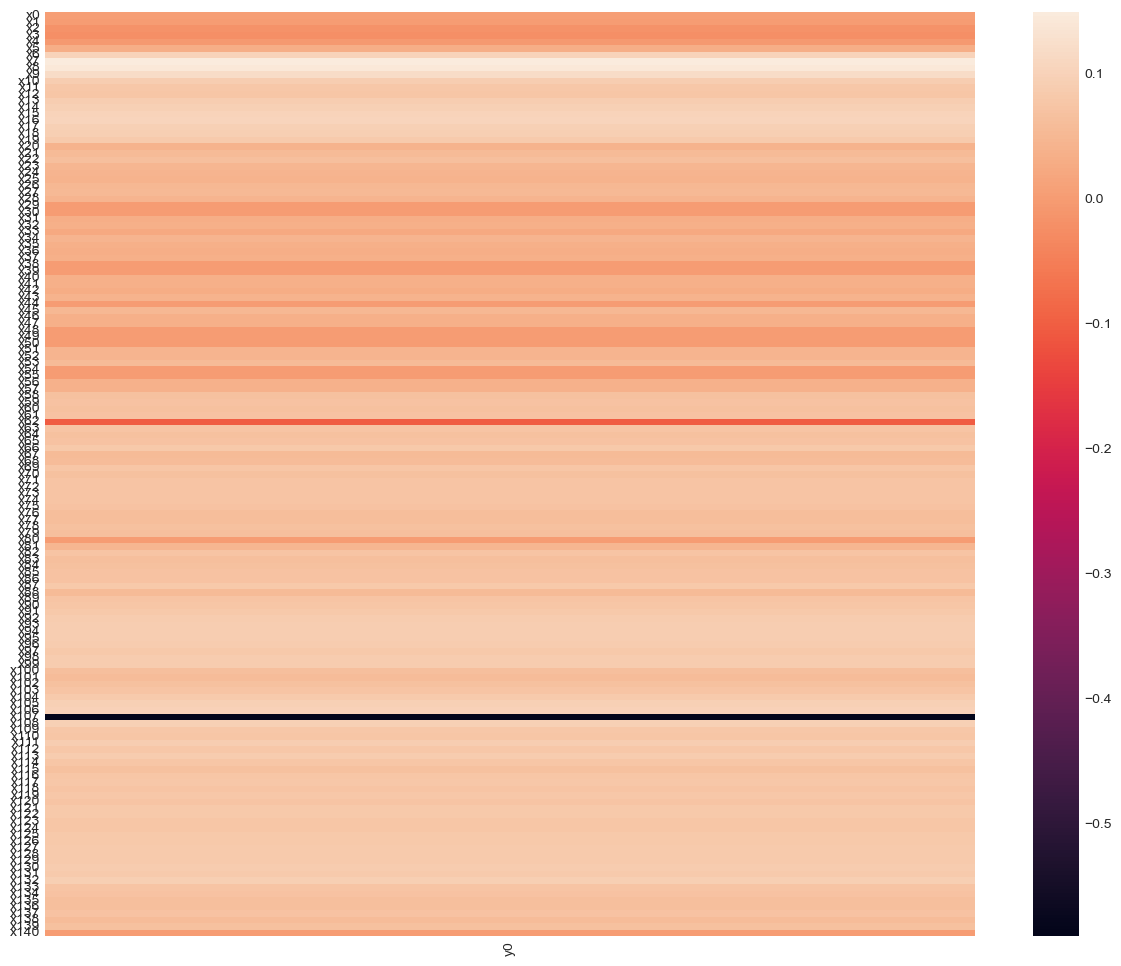

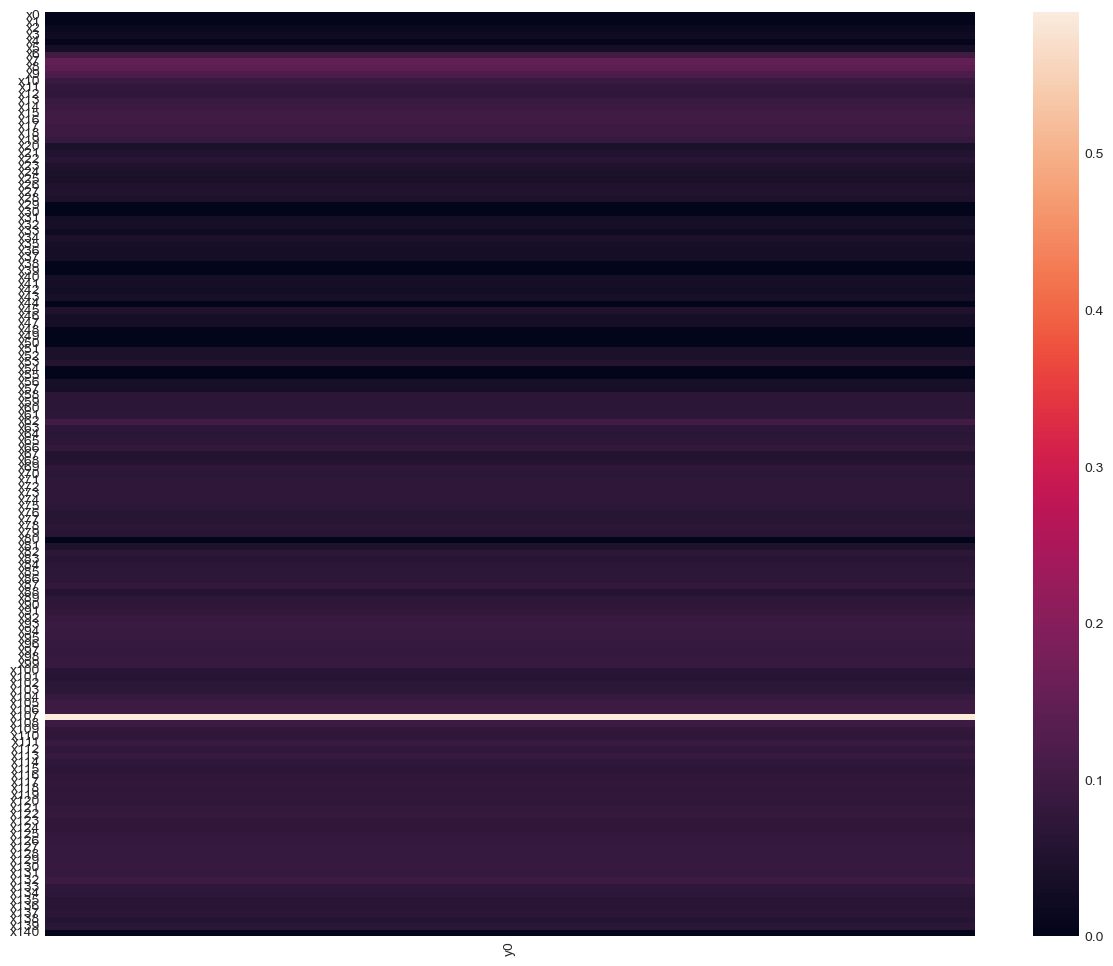

In [55]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)    
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [56]:
coarse_grain_coff = U[:, :rank]
print_equations(coarse_grain_coff, names, macro_name)

y0 = 0.0034 * x0 - 0.0007 * x1 - 0.0175 * x2 - 0.0233 * x3 - 0.0069 * x4 + 0.0327 * x5 + 0.1007 * x6 + 0.1484 * x7 + 0.1412 * x8 + 0.1194 * x9 + 0.0882 * x10 + 0.0768 * x11 + 0.0736 * x12 + 0.0885 * x13 + 0.0940 * x14 + 0.0994 * x15 + 0.1037 * x16 + 0.0943 * x17 + 0.0924 * x18 + 0.0830 * x19 + 0.0417 * x20 + 0.0534 * x21 + 0.0634 * x22 + 0.0468 * x23 + 0.0422 * x24 + 0.0400 * x25 + 0.0490 * x26 + 0.0518 * x27 + 0.0441 * x28 + 0.0007 * x30 + 0.0302 * x31 + 0.0358 * x32 + 0.0233 * x33 + 0.0436 * x34 + 0.0353 * x35 + 0.0324 * x36 + 0.0339 * x37 + 0.0359 * x40 + 0.0338 * x41 + 0.0283 * x42 + 0.0390 * x43 + 0.0489 * x45 + 0.0338 * x46 + 0.0333 * x47 + 0.0004 * x50 + 0.0422 * x51 + 0.0427 * x52 + 0.0554 * x53 + 0.0008 * x55 + 0.0372 * x56 + 0.0367 * x57 + 0.0675 * x58 + 0.0688 * x59 + 0.0675 * x60 + 0.0698 * x61 - 0.1050 * x62 + 0.0707 * x63 + 0.0667 * x64 + 0.0695 * x65 + 0.0806 * x66 + 0.0544 * x67 + 0.0565 * x68 + 0.0755 * x69 + 0.0668 * x70 + 0.0731 * x71 + 0.0726 * x72 + 0.0731 * x73 + 

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_31985/3986269945.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


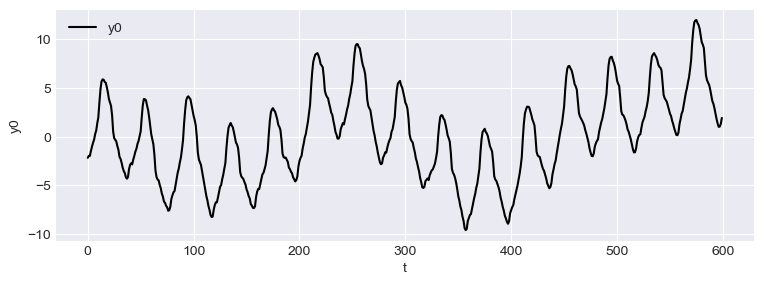

In [41]:
macro_data = x_data_lift[0] @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(9, int(3*macro_dim)))
for i in range(macro_dim):
    axs.plot(macro_data[:, i], "k", label=f"y{i}")
    axs.legend()
    axs.set(xlabel="t", ylabel=f"y{i}")
fig.show()

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_31985/3986269945.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


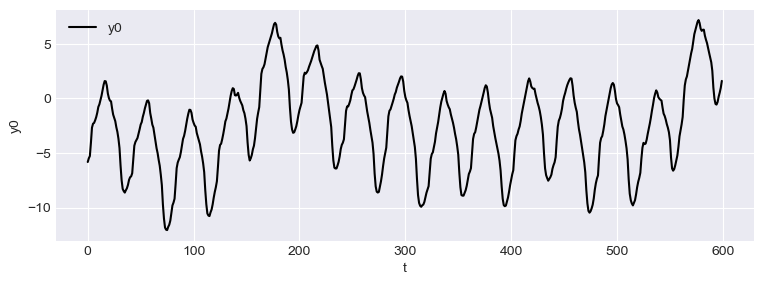

In [57]:
macro_data = x_data_lift[0] @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(9, int(3*macro_dim)))
for i in range(macro_dim):
    axs.plot(macro_data[:, i], "k", label=f"y{i}")
    axs.legend()
    axs.set(xlabel="t", ylabel=f"y{i}")
fig.show()